## Predicting Protein Carbonylation Capabilities with RDKit
Katie Schultz 12/6/2024 Molecular Informatics    **Used Python GPT for troubleshooting**
<br>
<br>

Oxidative stress results in the buildup of reactive oxygen species (ROS) that react with plasma and organelle membrane lipids, producing reactive (lipid) aldehydes. These aldehydes can then react with proteins and nucleic acids. **Protein Carbonylation** is an irreversible process involving the addition of carbonyl groups to Lys, Cys or His residues to form Michael adducts, though Schiff bases can also be formed from these interactions, and crosslinking, in which one aldehyde species carbonylates two separate amino acid residues has been observed.

Based on known crosslinking aldehydes, I've written some functions to help predict the carbonylation and crosslinking capabilities of various molecules from their SMILES codes. Data will be input as a list of SMILES strings, then output as a CSV file.

**Feedback for improved cutoff values, more appropriate properties to assess, and ways to simulate this (I've tried and failed multiple times with OpenMM) are greatly appreciated**

In [14]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
import pandas as pd
from IPython.display import display

**Step 1:** Input SMILES codes (pulled from PubChem)

In [4]:
smiles_list = [
    "CCCCCC(/C=C/C=O)O",            # 4-hydroxy-2-nonenal (4HNE)
    "C(C=O)C=O",                    # Malondialdehyde (MDA)
    "O",                            # Water (inorganic)
    "C=CC=O",                       # Acrolein
    "CC=O",                         # Acetaldehyde
    "CCC(C)=O"                      # Butanone
]

**Step 2:** Create function determining if the molecule is organic

In [5]:
def is_organic(smiles):
    return 'C' in smiles # this is a bit arbitrary; I could require a C-C bond
                         # I could include H as well, however SMILES codes usually written w/o H atoms

**Step 3:** Create function determining if the molecule has an aldehyde group

In [6]:
def contains_aldehyde(smiles):
    aldehyde_smarts = '[CX3H1](=O)[#6]' # used SMARTS instead of SMILES code to prevent ambiguity
    mol = Chem.MolFromSmiles(smiles)    # converting SMILES code to molecule object
    if mol:
        return mol.HasSubstructMatch(Chem.MolFromSmarts(aldehyde_smarts)) # converting aldehyde SMARTS to molecule object to
    return False                                                          # check for substructure match

**Step 4:** Create function determining number of double bonds (C=O, C=C, etc.)

In [7]:
def count_double_bonds(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return sum([1 for bond in mol.GetBonds() if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE])
    return 0

**Step 5:** Create function determining hydrophobicity (LogP)

In [8]:
def calculate_logp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolLogP(mol) # generally, LogP > 0 => lipophilic; LogP < 0 => hydrophilic, but we know it's not that simple
    return None

**Step 6:** Combine above functions into one function that will be output as a CSV file

In [9]:
def process_smiles(smiles_list, output_file="molecule_properties.csv"):
    """
    Processes a list of SMILES codes and calculates various properties.
    Exports the result as a CSV file and displays the table.
    """
    results = []
    for smiles in smiles_list:                      # processing list of SMILES
        organic_status = is_organic(smiles)
        aldehyde = contains_aldehyde(smiles)
        double_bonds = count_double_bonds(smiles)
        logp = calculate_logp(smiles)
        results.append({                            # adding successive results together
            'SMILES': smiles,
            'Is Organic': organic_status,
            'Contains Aldehyde': aldehyde,
            'Number of Double Bonds': double_bonds,
            'LogP': logp
        })
    
    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)             # converting results to a data frame and then exporting as CSV
    print(f"Results saved to {output_file}")
    
    print("\nGenerated CSV Table:")                 # printing the CSV
    print(df)


**Step 7:** Run the function

In [10]:
process_smiles(smiles_list)                        

Results saved to molecule_properties.csv

Generated CSV Table:
              SMILES  Is Organic  Contains Aldehyde  Number of Double Bonds  \
0  CCCCCC(/C=C/C=O)O        True               True                       2   
1          C(C=O)C=O        True               True                       2   
2                  O       False              False                       0   
3             C=CC=O        True               True                       2   
4               CC=O        True               True                       1   
5           CCC(C)=O        True              False                       1   

     LogP  
0  1.6827  
1 -0.2257  
2 -0.8247  
3  0.3713  
4  0.2052  
5  0.9854  


 Now we have all of the data in one spot. We can make (arbitrary) definitions for "carbonylating," "crosslinking," and "neither."

**Step 8:** Create a function classifying each molecule based on values in the outputted CSV file

In [11]:
def classify_molecules(input_file="molecule_properties.csv", output_file="classified_molecules.csv"):
    
    df = pd.read_csv(input_file)
    
    df['Carbonylating'] = (                     # all of these need to be true, hence the "&"
        (df['Is Organic'] == True) &
        (df['Contains Aldehyde'] == True) &
        (df['Number of Double Bonds'] > 0) &    # at least 1 double bond. This is the point of Michael Addition reactions
        (df['LogP'] < 1.8)                      # based on LogP of 4HNE, which could be a crosslinking aldehyde
    )
    
    df['Crosslinking'] = (
        (df['Is Organic'] == True) &
        (df['Contains Aldehyde'] == True) &
        (df['Number of Double Bonds'] > 1) &    # MDA and acrolein both contain 2 double bonds and have been observed to crosslink
        (df['LogP'] < 1.8)
    )
    
    df['Neither'] = (                           # just one of these has to be true to have it eliminated from carbonylating/crosslinking
        (df['Is Organic'] == False) |
        (df['Contains Aldehyde'] == False) |
        (df['Number of Double Bonds'] == 0) |
        (df['LogP'] > 1.8)            
    )
    
    df.to_csv(output_file, index=False)          # making new CSV file with additional columns
    print(f"Updated CSV with classifications saved to {output_file}")
    
    print("\nUpdated DataFrame with Classifications:")
    print(df)


**Step 9:** Run the function

In [12]:
classify_molecules()

Updated CSV with classifications saved to classified_molecules.csv

Updated DataFrame with Classifications:
              SMILES  Is Organic  Contains Aldehyde  Number of Double Bonds  \
0  CCCCCC(/C=C/C=O)O        True               True                       2   
1          C(C=O)C=O        True               True                       2   
2                  O       False              False                       0   
3             C=CC=O        True               True                       2   
4               CC=O        True               True                       1   
5           CCC(C)=O        True              False                       1   

     LogP  Carbonylating  Crosslinking  Neither  
0  1.6827           True          True    False  
1 -0.2257           True          True    False  
2 -0.8247          False         False     True  
3  0.3713           True          True    False  
4  0.2052           True         False    False  
5  0.9854          False         False

**Step 10:** Visualize the molecules to compare structural similarities

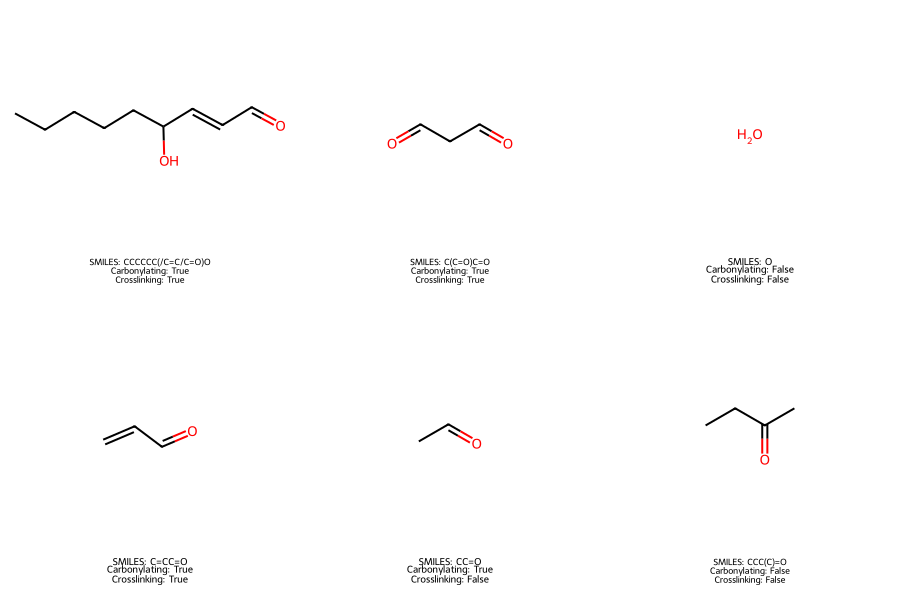

In [15]:
def visualize_molecules_with_smiles(input_file="classified_molecules.csv"):

    df = pd.read_csv(input_file)
    
    molecules = []
    labels = []
    for _, row in df.iterrows():
        smiles = row['SMILES']
        mol = Chem.MolFromSmiles(smiles)    # converting SMILES to Molecule Object to visualize
        if mol:
            molecules.append(mol)
            label = f"SMILES: {smiles}\nCarbonylating: {row['Carbonylating']}\nCrosslinking: {row['Crosslinking']}"
            labels.append(label)            # labelling w/ SMILES string & carbonylating/crosslinking status
    

    img = Draw.MolsToGridImage(
        molecules, 
        legends=labels, 
        molsPerRow=3, 
        subImgSize=(300, 300),
        useSVG=False
    )
    return img

img = visualize_molecules_with_smiles()
display(img)
